In [2]:
%pip install Pillow

Note: you may need to restart the kernel to use updated packages.


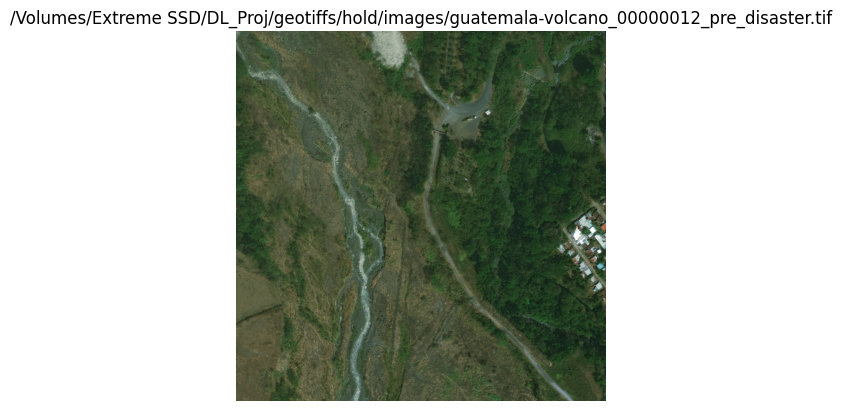

In [3]:
import matplotlib.pyplot as plt
import tifffile

image_path = '/Volumes/Extreme SSD/DL_Proj/geotiffs/hold/images/guatemala-volcano_00000012_pre_disaster.tif'  # Replace with your actual path

img = tifffile.imread(image_path)
plt.imshow(img, cmap='gray')
plt.title(image_path)
plt.axis('off')
plt.show()

In [2]:
import json

json_path = 'geotiffs/hold/labels/guatemala-volcano_00000004_post_disaster.json'  # Replace with your actual path

with open(json_path, encoding="utf-8") as fp:
    data = json.load(fp)

print(json.dumps(data, indent=2))

{
  "features": {
    "lng_lat": [
      {
        "properties": {
          "feature_type": "building",
          "subtype": "major-damage",
          "uid": "104d384e-412b-4a72-8361-3c6c75cafdf0"
        },
        "wkt": "POLYGON ((-90.832067814151 14.42973661152615, -90.83198135159103 14.42967876630043, -90.83204507143566 14.42958863344386, -90.83208152595631 14.42962017119394, -90.83210793558972 14.42958690007866, -90.8322374224695 14.42968516523737, -90.83221349607304 14.42970690267509, -90.83224532274491 14.4297382444936, -90.832067814151 14.42973661152615))"
      },
      {
        "properties": {
          "feature_type": "building",
          "subtype": "major-damage",
          "uid": "9badd81e-16bf-4406-b8ad-9cb50a208011"
        },
        "wkt": "POLYGON ((-90.83252997708334 14.42954147154196, -90.83240693146364 14.42962261218812, -90.83230910007273 14.42950468856743, -90.83244899884819 14.42941164582603, -90.83252806857338 14.42951308446236, -90.83251488806118 14.429521

In [5]:
import os
import json
import pandas as pd
from collections import defaultdict

label_folder = '/Volumes/Extreme SSD/DL_Proj/geotiffs/hold/labels'
json_files = [f for f in os.listdir(label_folder) if f.endswith('.json')]

issues = []
records = []
disaster_counts = defaultdict(int)
disaster_issues = defaultdict(int)

for f in json_files:
    disaster_name = f.split('_')[0]
    disaster_counts[disaster_name] += 1
    label_path = os.path.join(label_folder, f)
    try:
        with open(label_path, encoding="utf-8") as fp:
            data = json.load(fp)
        meta = data.get('metadata', {})
        features = data.get('features', {})
        xy = features.get('xy', [])
        lng_lat = features.get('lng_lat', [])

        # Check for missing fields
        problem = None
        if not meta:
            problem = 'Missing metadata'
        elif not features:
            problem = 'Missing features'
        elif not xy and not lng_lat:
            problem = 'No polygons in xy or lng_lat'
        
        if problem:
            issues.append({'file': f, 'problem': problem})
            disaster_issues[disaster_name] += 1

        # Flatten metadata
        record = {**meta, 'label_file': f, 'label_path': label_path}
        records.append(record)
    except Exception as e:
        issues.append({'file': f, 'problem': str(e)})
        disaster_issues[disaster_name] += 1

# Summary table
print("Disaster summary (total files, files with problems):")
summary = []
for disaster in disaster_counts:
    total = disaster_counts[disaster]
    problems = disaster_issues[disaster]
    print(f"{disaster}: {total} total, {problems} with problems")
    summary.append({'disaster': disaster, 'total': total, 'problems': problems})

# Advice
print("\nAdvice:")
print("If files are missing metadata or polygons, drop those rows for ML.")
print("If many files are affected, consider investigating or using CV to estimate damage if possible.")

# Optional: DataFrame for summary
df_summary = pd.DataFrame(summary)

# Save problematic file names and paths to CSV
problem_files = [issue['file'] for issue in issues if issue['problem'] in [
    'Missing metadata', 'Missing features', 'No polygons in xy or lng_lat']]
problem_paths = [os.path.join(label_folder, fname) for fname in problem_files]

df_problem = pd.DataFrame({'label_file': problem_files, 'label_path': problem_paths})
df_problem.to_csv(os.path.join(label_folder, 'problematic_label_files.csv'), index=False)
print("Problematic label files CSV saved.")

Disaster summary (total files, files with problems):
guatemala-volcano: 10 total, 0 with problems
hurricane-florence: 238 total, 16 with problems
hurricane-harvey: 190 total, 4 with problems
hurricane-matthew: 188 total, 10 with problems
hurricane-michael: 218 total, 4 with problems
mexico-earthquake: 68 total, 0 with problems
midwest-flooding: 172 total, 24 with problems
palu-tsunami: 82 total, 2 with problems
santa-rosa-wildfire: 154 total, 0 with problems
socal-fire: 546 total, 280 with problems

Advice:
If files are missing metadata or polygons, drop those rows for ML.
If many files are affected, consider investigating or using CV to estimate damage if possible.
Problematic label files CSV saved.


In [7]:
# making the csv for hold
import os
import json
import pandas as pd

label_folder = '/Volumes/Extreme SSD/DL_Proj/geotiffs/hold/labels'
image_folder = '/Volumes/Extreme SSD/DL_Proj/geotiffs/hold/images'
problematic_csv = os.path.join(label_folder, '/Volumes/Extreme SSD/DL_Proj/problematic_label_files.csv')

# Load problematic files
problematic_files = set(pd.read_csv(problematic_csv)['label_file'].tolist())

json_files = [f for f in os.listdir(label_folder) if f.endswith('.json') and f not in problematic_files]

records = []

for f in json_files:
    label_path = os.path.join(label_folder, f)
    with open(label_path, encoding="utf-8") as fp:
        data = json.load(fp)
    meta = data.get('metadata', {})
    img_name = meta.get('img_name', '')
    image_path = os.path.join(image_folder, img_name) if img_name else ''
    features = data.get('features', {})
    for source in ['xy', 'lng_lat']:
        for feat in features.get(source, []):
            prop = feat.get('properties', {})
            wkt = feat.get('wkt', '')
            record = {
                'label_file': f,
                'label_path': label_path,
                'img_name': img_name,
                'image_path': image_path,
                **meta,
                'feature_type': prop.get('feature_type', ''),
                'subtype': prop.get('subtype', ''),
                'uid': prop.get('uid', ''),
                'wkt': wkt,
                'source': source
            }
            records.append(record)

df = pd.DataFrame(records)
df.to_csv(os.path.join(label_folder, 'labels_polygons_flattened.csv'), index=False)
print("Flattened CSV saved with image paths included.")

Flattened CSV saved with image paths included.


In [8]:
hold_csv = pd.read_csv("/Volumes/Extreme SSD/DL_Proj/labels_polygons_flattened.csv")
hold_csv.head(1)

,label_file,label_path,img_name,image_path,sensor,provider_asset_type,gsd,capture_date,off_nadir_angle,pan_resolution,...,original_width,original_height,width,height,id,feature_type,subtype,uid,wkt,source
0,guatemala-volcano_00000004_post_disaster.json,/Volumes/Extreme SSD/DL_Proj/geotiffs/hold/lab...,guatemala-volcano_00000004_post_disaster.png,/Volumes/Extreme SSD/DL_Proj/geotiffs/hold/ima...,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22T16:55:40.000Z,21.97336,0.351739,...,1024,1024,1024,1024,MjU0NzE2OA.QTj5LivR1BWXmCHLpFrtSU5PNH0,building,major-damage,104d384e-412b-4a72-8361-3c6c75cafdf0,"POLYGON ((212.2425241572 0.005244624768526229,...",xy


In [ ]:
# adding a damage percent column

from shapely import wkt
import pandas as pd

df = pd.read_csv("/Volumes/Extreme SSD/DL_Proj/labels_polygons_flattened.csv")
damage_types = ['major-damage', 'minor-damage', 'destroyed']

# Get base name (without _pre/_post_disaster.png)
df['base_name'] = df['img_name'].str.replace('_pre_disaster.png', '').str.replace('_post_disaster.png', '')

damage_percent_map = {}

for base_name, group in df.groupby('base_name'):
    # Pre-disaster
    pre_mask = group['img_name'].str.contains('_pre_disaster.png')
    post_mask = group['img_name'].str.contains('_post_disaster.png')
    
    # Calculate damage percent for post-disaster
    if post_mask.any():
        post_group = group[post_mask]
        damage_area = post_group[post_group['subtype'].isin(damage_types)]['wkt'].apply(lambda x: wkt.loads(x).area if x else 0).sum()
        total_area = post_group['width'].iloc[0] * post_group['height'].iloc[0]
        damage_percent = 100 * damage_area / total_area if total_area > 0 else 0.0
        # Assign to post-disaster rows
        for idx in post_group.index:
            damage_percent_map[idx] = damage_percent
    # Pre-disaster always 0
    if pre_mask.any():
        for idx in group[pre_mask].index:
            damage_percent_map[idx] = 0.0

# Add column
df['damage_percent'] = df.index.map(damage_percent_map)
df.to_csv("/Volumes/Extreme SSD/DL_Proj/labels_polygons_flattened_with_damage.csv", index=False)
print("CSV saved with damage_percent column (pre=0, post=calculated).")

Using MPS device


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [3]:
!pip install tifffile


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Using MPS device


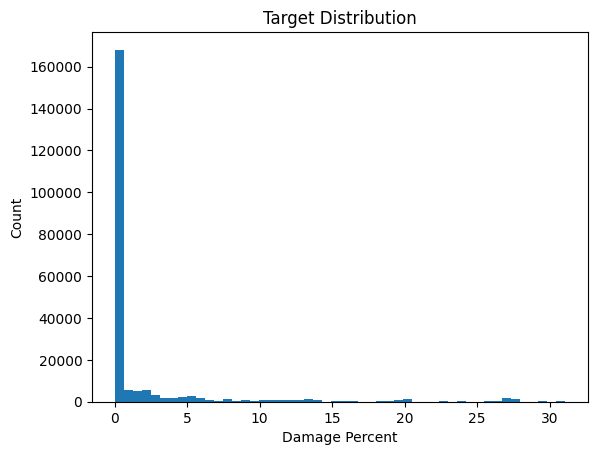

Fold 4 Epoch 0 [Val]:  20%|██        | 1/5 [00:02<00:09,  2.44s/it, val_loss=0.666]  

Predicted: [6.7925881e-05 7.1941897e-05 1.3690684e-06 2.8416737e-06 4.6001655e-06]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 0 [Val]:  40%|████      | 2/5 [00:04<00:07,  2.42s/it, val_loss=2.77] 

Predicted: [5.9455547e-06 5.0476508e-05 3.1547297e-05 2.1888927e-05 9.2706196e-06]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 0 [Val]:  60%|██████    | 3/5 [00:07<00:04,  2.36s/it, val_loss=1.26]

Predicted: [7.1025133e-05 1.8118855e-05 4.2433145e-05 5.5739343e-05 9.3654140e-05]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 0 [Val]:  80%|████████  | 4/5 [00:10<00:02,  2.58s/it, val_loss=0.752]

Predicted: [1.6563728e-04 1.1537952e-06 8.2162596e-06 3.2956639e-06 3.7275734e-06]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [1.0731770e-05 2.9441457e-05 1.3398055e-05 1.5156712e-04 4.9216454e-05]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 0 Val Loss: 1.1727


Fold 4 Epoch 1 [Val]:  20%|██        | 1/5 [00:02<00:09,  2.49s/it, val_loss=0.666]

Predicted: [6.7876285e-06 1.2021913e-05 1.6310814e-08 5.1022582e-08 2.2056925e-07]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 1 [Val]:  40%|████      | 2/5 [00:05<00:07,  2.58s/it, val_loss=2.77] 

Predicted: [9.5620317e-07 1.2644128e-05 6.2961890e-06 4.5488100e-06 1.9784790e-07]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 1 [Val]:  60%|██████    | 3/5 [00:07<00:04,  2.45s/it, val_loss=1.26]

Predicted: [2.5853442e-05 4.2314250e-06 1.6451888e-05 1.3261133e-05 3.5776520e-05]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 1 [Val]:  80%|████████  | 4/5 [00:09<00:02,  2.46s/it, val_loss=0.752]

Predicted: [1.7231284e-06 2.3226907e-08 5.8993743e-07 2.4374685e-07 4.4508056e-07]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [2.7333845e-06 8.0697391e-06 4.6245777e-06 3.1950840e-05 1.5251787e-05]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 1 Val Loss: 1.1727


Fold 4 Epoch 2 [Val]:  20%|██        | 1/5 [00:02<00:09,  2.39s/it, val_loss=0.666]

Predicted: [1.4484305e-05 1.9733212e-05 4.6014506e-08 1.3979221e-07 4.0147447e-07]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 2 [Val]:  40%|████      | 2/5 [00:05<00:07,  2.53s/it, val_loss=2.77] 

Predicted: [1.3741121e-06 1.5559397e-05 8.6385144e-06 6.9606235e-06 2.9862832e-07]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 2 [Val]:  60%|██████    | 3/5 [00:07<00:04,  2.40s/it, val_loss=1.26]

Predicted: [3.3522214e-05 5.0192903e-06 1.7175869e-05 1.8440569e-05 3.9964263e-05]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 2 [Val]:  80%|████████  | 4/5 [00:09<00:02,  2.46s/it, val_loss=0.752]

Predicted: [1.8086635e-06 6.5118492e-08 1.0766847e-06 4.2033176e-07 7.9460040e-07]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [6.3813141e-06 9.8893051e-06 6.3964862e-06 3.7643200e-05 1.6033950e-05]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 2 Val Loss: 1.1727


Fold 4 Epoch 3 [Val]:  20%|██        | 1/5 [00:02<00:09,  2.50s/it, val_loss=0.666] 

Predicted: [1.8732931e-05 3.3085507e-05 5.5680211e-08 2.1073457e-07 7.5847913e-07]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 3 [Val]:  40%|████      | 2/5 [00:05<00:08,  2.67s/it, val_loss=2.77] 

Predicted: [2.7809604e-06 3.3139666e-05 1.8992345e-05 1.5343508e-05 4.3223434e-07]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 3 [Val]:  60%|██████    | 3/5 [00:07<00:05,  2.57s/it, val_loss=1.26]

Predicted: [5.7457062e-05 9.8815754e-06 3.2559488e-05 3.2958091e-05 8.1180726e-05]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 3 [Val]:  80%|████████  | 4/5 [00:10<00:02,  2.53s/it, val_loss=0.752]

Predicted: [3.5010430e-06 8.4236483e-08 1.9893478e-06 8.4618659e-07 1.4321438e-06]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [7.7504137e-06 1.8524808e-05 1.0628107e-05 6.7006855e-05 3.0112289e-05]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 3 Val Loss: 1.1727


Fold 4 Epoch 4 [Val]:  20%|██        | 1/5 [00:02<00:10,  2.59s/it, val_loss=0.666]

Predicted: [1.17583026e-04 1.66244645e-04 5.31228579e-07 1.80366476e-06
 5.68895666e-06]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 4 [Val]:  40%|████      | 2/5 [00:05<00:07,  2.60s/it, val_loss=2.77] 

Predicted: [1.7623473e-05 1.6942785e-04 1.0252685e-04 8.4300351e-05 3.2610537e-06]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 4 [Val]:  60%|██████    | 3/5 [00:07<00:04,  2.49s/it, val_loss=1.26]

Predicted: [2.8040502e-04 6.1607228e-05 1.7104892e-04 1.6791915e-04 3.7491217e-04]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 4 [Val]:  80%|████████  | 4/5 [00:10<00:02,  2.50s/it, val_loss=0.752]

Predicted: [1.8807399e-05 8.0149727e-07 1.3274470e-05 6.4380529e-06 1.1647138e-05]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [6.1367624e-05 1.1372109e-04 7.5351614e-05 3.1920095e-04 1.7310432e-04]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 4 Val Loss: 1.1726


Fold 4 Epoch 5 [Val]:  20%|██        | 1/5 [00:02<00:09,  2.46s/it, val_loss=0.666] 

Predicted: [3.1384340e-04 4.9637194e-04 2.9712799e-06 2.6865916e-06 1.1793943e-05]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 5 [Val]:  40%|████      | 2/5 [00:05<00:07,  2.55s/it, val_loss=2.77] 

Predicted: [2.1087466e-05 7.3747615e-05 3.7277197e-05 1.8431429e-05 4.6174305e-06]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 5 [Val]:  60%|██████    | 3/5 [00:07<00:05,  2.50s/it, val_loss=1.26]

Predicted: [8.9271707e-05 2.7207610e-05 9.7667275e-05 9.7509248e-05 1.7011852e-04]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 5 [Val]:  80%|████████  | 4/5 [00:10<00:02,  2.56s/it, val_loss=0.752]

Predicted: [2.1880784e-05 4.2275856e-06 2.2521726e-05 1.7930970e-05 1.5340478e-05]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [1.4617537e-05 9.3754759e-05 3.5631641e-05 1.9550255e-04 2.3647476e-04]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 5 Val Loss: 1.1727


Fold 4 Epoch 6 [Val]:  20%|██        | 1/5 [00:02<00:10,  2.54s/it, val_loss=0.666]

Predicted: [2.8429751e-04 4.9073593e-04 1.5097024e-06 1.3070919e-06 6.6540465e-06]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 6 [Val]:  40%|████      | 2/5 [00:05<00:08,  2.69s/it, val_loss=2.77] 

Predicted: [1.21488201e-05 6.05950263e-05 2.28907957e-05 1.22969395e-05
 1.60508500e-06]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 6 [Val]:  60%|██████    | 3/5 [00:07<00:05,  2.53s/it, val_loss=1.26]

Predicted: [2.6059519e-05 1.1484393e-05 4.6573568e-05 4.8816226e-05 7.7128156e-05]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 6 [Val]:  80%|████████  | 4/5 [00:10<00:02,  2.55s/it, val_loss=0.752]

Predicted: [2.2118449e-05 1.7044053e-06 8.5747706e-06 1.1362608e-05 9.7332386e-06]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [5.8972723e-06 6.6389024e-05 2.3225632e-05 9.0418907e-05 2.1051953e-04]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 6 Val Loss: 1.1727


Fold 4 Epoch 7 [Val]:  20%|██        | 1/5 [00:02<00:11,  2.95s/it, val_loss=0.666]   

Predicted: [3.0323514e-04 6.0028874e-04 1.4532160e-06 1.3873668e-06 8.1531280e-06]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 7 [Val]:  40%|████      | 2/5 [00:05<00:08,  2.72s/it, val_loss=2.77] 

Predicted: [1.5934575e-05 8.2026025e-05 3.6261990e-05 1.8091021e-05 1.9275647e-06]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 7 [Val]:  60%|██████    | 3/5 [00:07<00:05,  2.57s/it, val_loss=1.26]

Predicted: [5.1927640e-05 1.9037516e-05 6.4710643e-05 5.5261080e-05 1.1890644e-04]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 7 [Val]:  80%|████████  | 4/5 [00:10<00:02,  2.54s/it, val_loss=0.752]

Predicted: [5.2568266e-05 1.3763497e-06 1.0282819e-05 1.4700045e-05 1.3747444e-05]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [7.3882079e-06 9.9543264e-05 3.2979500e-05 1.2422616e-04 3.0554002e-04]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 7 Val Loss: 1.1727


Fold 4 Epoch 8 [Val]:  20%|██        | 1/5 [00:02<00:08,  2.14s/it, val_loss=0.666]

Predicted: [4.9941981e-04 9.8045252e-04 1.4814118e-06 1.3163517e-06 8.5173124e-06]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 8 [Val]:  40%|████      | 2/5 [00:04<00:07,  2.50s/it, val_loss=2.77] 

Predicted: [2.3278497e-05 7.5491800e-05 3.7808331e-05 2.0586505e-05 2.2510299e-06]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 8 [Val]:  60%|██████    | 3/5 [00:07<00:04,  2.35s/it, val_loss=1.26]

Predicted: [4.8118880e-05 2.7079630e-05 1.0498564e-04 8.1099002e-05 1.3534172e-04]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 8 [Val]:  80%|████████  | 4/5 [00:09<00:02,  2.33s/it, val_loss=0.752]

Predicted: [4.0341602e-05 2.3183954e-06 1.5649457e-05 1.8028710e-05 1.9583476e-05]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [9.8116170e-06 1.1307170e-04 4.9881921e-05 1.4424496e-04 3.0792435e-04]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 8 Val Loss: 1.1727


Fold 4 Epoch 9 [Val]:  20%|██        | 1/5 [00:02<00:09,  2.25s/it, val_loss=0.666]

Predicted: [3.5227876e-04 7.8408455e-04 1.3617503e-06 1.3063193e-06 7.7270042e-06]
Ground Truth: [0.         0.05455452 1.7098938  0.830208   0.84452945]


Fold 4 Epoch 9 [Val]:  40%|████      | 2/5 [00:04<00:07,  2.37s/it, val_loss=2.77] 

Predicted: [1.5724079e-05 9.6437863e-05 4.3971802e-05 1.6841490e-05 2.8287384e-06]
Ground Truth: [1.1313766  0.         0.         0.         0.11414362]


Fold 4 Epoch 9 [Val]:  60%|██████    | 3/5 [00:06<00:04,  2.28s/it, val_loss=1.26]

Predicted: [8.1925100e-05 2.0716550e-05 8.8839246e-05 6.2825435e-05 1.4610792e-04]
Ground Truth: [2.9016266 1.2158234 4.105656  7.071918  5.1199684]


Fold 4 Epoch 9 [Val]:  80%|████████  | 4/5 [00:09<00:02,  2.29s/it, val_loss=0.752]

Predicted: [7.7570832e-05 1.5725125e-06 1.2553856e-05 1.7646798e-05 1.6897797e-05]
Ground Truth: [0.25757742 0.         0.09545032 0.         0.1691795 ]


Predicted: [6.2886156e-06 8.7544460e-05 2.7899290e-05 1.5275458e-04 2.9199384e-04]
Ground Truth: [0.         0.09383044 0.         0.         0.3778862 ]
Fold 4 Epoch 9 Val Loss: 1.1727
Early stopping at epoch 9
Training complete.


In [16]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import tifffile
from tqdm import tqdm
import matplotlib.pyplot as plt

def ensure_tif(df):
    df['img_name'] = df['img_name'].str.replace('.png', '.tif')
    df['image_path'] = df['image_path'].str.replace('.png', '.tif')
    return df

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

df = pd.read_csv("/Volumes/Extreme SSD/DL_Proj/labels_polygons_flattened_with_damage.csv")
df = ensure_tif(df)
df['base_name'] = df['img_name'].str.replace('_pre_disaster.tif', '').str.replace('_post_disaster.tif', '')

# Plot target distribution
plt.hist(df['damage_percent'], bins=50)
plt.xlabel('Damage Percent')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()

valid_bases = df.groupby('base_name')['img_name'].nunique()
valid_bases = valid_bases[valid_bases == 2].index
df = df[df['base_name'].isin(valid_bases)]

image_df = df.drop_duplicates(subset=['img_name'])
meta_cols = ['gsd', 'sun_azimuth', 'sun_elevation', 'off_nadir_angle', 'pan_resolution']
scaler = StandardScaler()
meta_features = scaler.fit_transform(image_df[meta_cols].fillna(0))

pairs = []
for base in valid_bases:
    pre_row = image_df[(image_df['base_name'] == base) & (image_df['img_name'].str.contains('pre_disaster'))].iloc[0]
    post_row = image_df[(image_df['base_name'] == base) & (image_df['img_name'].str.contains('post_disaster'))].iloc[0]
    pairs.append({
        'pre_image_path': pre_row['image_path'],
        'post_image_path': post_row['image_path'],
        'meta': post_row[meta_cols].values.astype(float),
        'damage_percent': post_row['damage_percent']
    })

class DamagePairDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pre_img = tifffile.imread(self.pairs[idx]['pre_image_path'])
        post_img = tifffile.imread(self.pairs[idx]['post_image_path'])
        if pre_img.ndim == 2:
            pre_img = np.stack([pre_img]*3, axis=-1)
        if post_img.ndim == 2:
            post_img = np.stack([post_img]*3, axis=-1)
        if pre_img.shape[-1] == 3:
            pre_img = np.transpose(pre_img, (2, 0, 1))
        if post_img.shape[-1] == 3:
            post_img = np.transpose(post_img, (2, 0, 1))
        pre_img = pre_img.astype(np.float32)
        post_img = post_img.astype(np.float32)
        pre_img /= pre_img.max() if pre_img.max() > 0 else 1
        post_img /= post_img.max() if post_img.max() > 0 else 1
        img_pair = np.concatenate([pre_img, post_img], axis=0)
        img_pair = torch.tensor(img_pair, dtype=torch.float32)
        if self.transform:
            img_pair = self.transform(img_pair)
        meta = torch.tensor(self.pairs[idx]['meta'], dtype=torch.float32)
        target = torch.tensor(self.pairs[idx]['damage_percent'], dtype=torch.float32)
        return img_pair, meta, target

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406, 0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225, 0.229, 0.224, 0.225])
])

class MultiLayerDamageCNN(nn.Module):
    def __init__(self, meta_dim):
        super().__init__()
        self.img_cnn = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.meta_fc = nn.Sequential(
            nn.Linear(meta_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.final_fc = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def forward(self, x_img, x_meta):
        img_feat = self.img_cnn(x_img)
        img_feat = img_feat.view(img_feat.size(0), -1)
        meta_feat = self.meta_fc(x_meta)
        x = torch.cat([img_feat, meta_feat], dim=1)
        out = self.final_fc(x)
        return out.squeeze(1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
pairs = np.array(pairs)

fold_num = 4  # Only train on fold 4
early_stop_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for fold, (train_idx, val_idx) in enumerate(kf.split(pairs)):
    if fold != fold_num:
        continue

    train_ds = DamagePairDataset(pairs[train_idx], transform)
    val_ds = DamagePairDataset(pairs[val_idx], transform)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    model = MultiLayerDamageCNN(meta_dim=len(meta_cols)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.SmoothL1Loss()

    for epoch in range(30):
        model.train()
        train_iter = tqdm(train_loader, desc=f"Fold {fold} Epoch {epoch} [Train]", leave=False)
        for img_pair, meta, target in train_iter:
            img_pair, meta, target = img_pair.to(device), meta.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(img_pair, meta)
            loss = criterion(output * 100, target)
            loss.backward()
            optimizer.step()
            train_iter.set_postfix(loss=loss.item())
        model.eval()
        val_losses = []
        val_iter = tqdm(val_loader, desc=f"Fold {fold} Epoch {epoch} [Val]", leave=False)
        with torch.no_grad():
            for img_pair, meta, target in val_iter:
                img_pair, meta, target = img_pair.to(device), meta.to(device), target.to(device)
                output = model(img_pair, meta)
                val_loss = criterion(output * 100, target)
                val_losses.append(val_loss.item())
                val_iter.set_postfix(val_loss=val_loss.item())
                # Print predictions vs ground truth for every batch
                print("Predicted:", (output[:5] * 100).detach().cpu().numpy())
                print("Ground Truth:", target[:5].detach().cpu().numpy())
        avg_val_loss = np.mean(val_losses)
        print(f"Fold {fold} Epoch {epoch} Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping at epoch {epoch}")
                break

print("Training complete.")

In [3]:
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import glob
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import tifffile
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp  # pip install segmentation-models-pytorch
from shapely import wkt

# --- Mask Creation from WKT ---
def create_mask_from_wkt(image_shape, wkt_list):
    mask = Image.new('L', image_shape[::-1], 0)
    draw = ImageDraw.Draw(mask)
    for wkt_str in wkt_list:
        poly = wkt.loads(wkt_str)
        coords = [(x, y) for x, y in np.array(poly.exterior.coords)]
        draw.polygon(coords, outline=1, fill=1)
    return np.array(mask, dtype=np.uint8)

# --- Read all JSONs in the folder ---
json_folder = "/Volumes/Extreme SSD/DL_Proj/geotiffs/tier1/labels"  # <-- set your JSON folder path here
image_folder = "/Volumes/Extreme SSD/DL_Proj/geotiffs/tier1/images"  # <-- set your image folder path here

damage_types = ['major-damage', 'minor-damage', 'destroyed']
json_files = glob.glob(os.path.join(json_folder, "*.json"))
samples = []
for json_file in tqdm(json_files, desc="Loading JSONs"):
    img_name = os.path.splitext(os.path.basename(json_file))[0]
    img_path = os.path.join(image_folder, img_name + ".tif")
    if not os.path.exists(img_path):
        img_path = os.path.join(image_folder, img_name + ".png")
    img = tifffile.imread(img_path)
    height, width = img.shape[:2]
    with open(json_file) as f:
        data = json.load(f)
    wkt_list = []
    for poly in data['features']['xy']:
        subtype = poly.get('properties', {}).get('subtype', None)
        if subtype in damage_types and 'wkt' in poly:
            wkt_list.append(poly['wkt'])
    mask = create_mask_from_wkt((height, width), wkt_list)
    samples.append({
        'pre_image_path': img_path,
        'post_image_path': img_path,  # If you have separate pre/post, update here
        'mask': mask
    })

# --- Dataset ---
class DisasterSegmentationDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = tifffile.imread(sample['pre_image_path'])
        # Ensure RGB
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        img /= img.max() if img.max() > 0 else 1
        # For now, use the same image for pre/post (6 channels)
        img_pair = np.concatenate([img, img], axis=0)  # [6, H, W]
        mask = sample['mask'].astype(np.float32)
        if self.transform:
            augmented = self.transform(image=img_pair.transpose(1,2,0), mask=mask)
            img_pair = augmented['image']
            mask = augmented['mask']
        return img_pair, mask

# --- Augmentation ---
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=[0.485]*6, std=[0.229]*6),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485]*6, std=[0.229]*6),
    ToTensorV2()
])

# --- Data Preparation ---
dataset = DisasterSegmentationDataset(samples, transform=train_transform)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_ds.dataset.transform = val_transform  # Set validation transform

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

# --- Model: U-Net with ResNet Encoder ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,
    classes=1,
    activation=None
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# --- IoU and Dice metric functions ---
def compute_iou(pred, target):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2))
    union = ((pred + target) > 0).float().sum(dim=(1,2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def compute_dice(pred, target):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2))
    dice = (2 * intersection + 1e-6) / (pred.sum(dim=(1,2)) + target.sum(dim=(1,2)) + 1e-6)
    return dice.mean().item()

# --- Training Loop with IoU/Dice and Model Saving ---
best_val_iou = 0
early_stop_patience = 5
epochs_no_improve = 0

for epoch in range(30):
    model.train()
    train_iter = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    train_losses = []
    for img_pair, mask in train_iter:
        img_pair, mask = img_pair.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(img_pair)
        loss = criterion(output.squeeze(1), mask)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_iter.set_postfix(loss=loss.item())
    print(f"Epoch {epoch} Train Loss: {np.mean(train_losses):.4f}")

    # Validation
    model.eval()
    val_losses = []
    val_ious = []
    val_dices = []
    val_iter = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
    with torch.no_grad():
        for img_pair, mask in val_iter:
            img_pair, mask = img_pair.to(device), mask.to(device)
            output = model(img_pair)
            loss = criterion(output.squeeze(1), mask)
            val_losses.append(loss.item())
            pred = torch.sigmoid(output.squeeze(1))
            val_ious.append(compute_iou(pred.cpu(), mask.cpu()))
            val_dices.append(compute_dice(pred.cpu(), mask.cpu()))
            val_iter.set_postfix(val_loss=loss.item())
    avg_val_loss = np.mean(val_losses)
    avg_val_iou = np.mean(val_ious)
    avg_val_dice = np.mean(val_dices)
    print(f"Epoch {epoch} Val Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f} | Dice: {avg_val_dice:.4f}")

    # Save best model and weights based on IoU
    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        epochs_no_improve = 0
        torch.save(model, "best_model.pt")
        torch.save(model.state_dict(), "best_weights.pt")
        print(f"Best model saved at epoch {epoch}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping at epoch {epoch}")
            break

print("Training complete.")

/Users/yatharthnehva/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading JSONs: 100%|██████████| 5598/5598 [08:58<00:00, 10.40it/s]


Epoch 0 Train Loss: 0.1234


Epoch 0 Val Loss: 0.0577 | IoU: 0.7443 | Dice: 0.7443
Best model saved at epoch 0


Epoch 1 Train Loss: 0.0502


Epoch 1 Val Loss: 0.0598 | IoU: 0.7443 | Dice: 0.7443


Epoch 2 Train Loss: 0.0419


Epoch 2 Val Loss: 0.0549 | IoU: 0.7443 | Dice: 0.7443


Epoch 3 Train Loss: 0.0389


Epoch 3 Val Loss: 0.0430 | IoU: 0.7443 | Dice: 0.7443


Epoch 4 Train Loss: 0.0367


Epoch 4 Val Loss: 0.0658 | IoU: 0.7443 | Dice: 0.7443


Epoch 5 Train Loss: 0.0349


Epoch 5 Val Loss: 0.0484 | IoU: 0.7443 | Dice: 0.7443
Early stopping at epoch 5
Training complete.


In [9]:
# --- Test Loop with IoU and Dice ---
test_image_folder = "/Volumes/Extreme SSD/DL_Proj/geotiffs/test/images"   # <-- set your test image folder
test_label_folder = "/Volumes/Extreme SSD/DL_Proj/geotiffs/test/labels"   # <-- set your test label folder

test_json_files = glob.glob(os.path.join(test_label_folder, "*.json"))
test_samples = []
for json_file in tqdm(test_json_files, desc="Loading Test JSONs"):
    img_name = os.path.splitext(os.path.basename(json_file))[0]
    img_path = os.path.join(test_image_folder, img_name + ".tif")
    if not os.path.exists(img_path):
        img_path = os.path.join(test_image_folder, img_name + ".png")
    img = tifffile.imread(img_path)
    height, width = img.shape[:2]
    with open(json_file) as f:
        data = json.load(f)
    wkt_list = []
    for poly in data['features']['xy']:
        subtype = poly.get('properties', {}).get('subtype', None)
        if subtype in damage_types and 'wkt' in poly:
            wkt_list.append(poly['wkt'])
    mask = create_mask_from_wkt((height, width), wkt_list)
    test_samples.append({
        'pre_image_path': img_path,
        'post_image_path': img_path,
        'mask': mask
    })

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485]*6, std=[0.229]*6),
    ToTensorV2()
])

test_dataset = DisasterSegmentationDataset(test_samples, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1)

model.eval()
ious = []
dices = []
with torch.no_grad():
    for img_pair, mask in tqdm(test_loader, desc="Testing"):
        img_pair, mask = img_pair.to(device), mask.to(device)
        output = model(img_pair)
        pred = torch.sigmoid(output.squeeze(1))
        ious.append(compute_iou(pred.cpu(), mask.cpu()))
        dices.append(compute_dice(pred.cpu(), mask.cpu()))

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)
print(f"Test Mean IoU: {mean_iou:.4f}")
print(f"Test Mean Dice: {mean_dice:.4f}")

Testing: 100%|██████████| 1866/1866 [03:05<00:00, 10.04it/s]

Test Mean IoU: 0.7417
Test Mean Dice: 0.7417


In [10]:
# version 2

import os
import glob
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import tifffile
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from shapely import wkt

# --- Mask Creation from WKT ---
def create_mask_from_wkt(image_shape, wkt_list):
    mask = Image.new('L', image_shape[::-1], 0)
    draw = ImageDraw.Draw(mask)
    for wkt_str in wkt_list:
        poly = wkt.loads(wkt_str)
        coords = [(x, y) for x, y in np.array(poly.exterior.coords)]
        draw.polygon(coords, outline=1, fill=1)
    return np.array(mask, dtype=np.uint8)

# --- Read all JSONs in the folder ---
json_folder = "/Volumes/Extreme SSD/DL_Proj/geotiffs/tier1/labels"  # <-- set your JSON folder path here
image_folder = "/Volumes/Extreme SSD/DL_Proj/geotiffs/tier1/images"  # <-- set your image folder path here

damage_types = ['major-damage', 'minor-damage', 'destroyed']
json_files = glob.glob(os.path.join(json_folder, "*.json"))
samples = []
for json_file in tqdm(json_files, desc="Loading JSONs"):
    img_name = os.path.splitext(os.path.basename(json_file))[0]
    img_path = os.path.join(image_folder, img_name + ".tif")
    if not os.path.exists(img_path):
        img_path = os.path.join(image_folder, img_name + ".png")
    img = tifffile.imread(img_path)
    height, width = img.shape[:2]
    with open(json_file) as f:
        data = json.load(f)
    wkt_list = []
    for poly in data['features']['xy']:
        subtype = poly.get('properties', {}).get('subtype', None)
        if subtype in damage_types and 'wkt' in poly:
            wkt_list.append(poly['wkt'])
    mask = create_mask_from_wkt((height, width), wkt_list)
    samples.append({
        'pre_image_path': img_path,
        'post_image_path': img_path,
        'mask': mask
    })

# --- Dataset ---
class DisasterSegmentationDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = tifffile.imread(sample['pre_image_path'])
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        img /= img.max() if img.max() > 0 else 1
        img_pair = np.concatenate([img, img], axis=0)  # [6, H, W]
        mask = sample['mask'].astype(np.float32)
        if self.transform:
            augmented = self.transform(image=img_pair.transpose(1,2,0), mask=mask)
            img_pair = augmented['image']
            mask = augmented['mask']
        return img_pair, mask

# --- Stronger Augmentation ---
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.485]*6, std=[0.229]*6),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485]*6, std=[0.229]*6),
    ToTensorV2()
])

# --- Data Preparation ---
dataset = DisasterSegmentationDataset(samples, transform=train_transform)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_ds.dataset.transform = val_transform

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

# --- Model: U-Net with Stronger Encoder ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = smp.Unet(
    encoder_name="resnet50",  # Try "efficientnet-b3" or "resnext50_32x4d" for even stronger
    encoder_weights="imagenet",
    in_channels=6,
    classes=1,
    activation=None
).to(device)

# --- Dice + BCE Loss ---
class DiceLoss(nn.Module):
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        smooth = 1e-6
        intersection = (pred * target).sum()
        dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        return 1 - dice

def combined_loss(output, target):
    return nn.BCEWithLogitsLoss()(output, target) + DiceLoss()(output, target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --- IoU and Dice metric functions ---
def compute_iou(pred, target):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2))
    union = ((pred + target) > 0).float().sum(dim=(1,2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def compute_dice(pred, target):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2))
    dice = (2 * intersection + 1e-6) / (pred.sum(dim=(1,2)) + target.sum(dim=(1,2)) + 1e-6)
    return dice.mean().item()

# --- Training Loop with IoU/Dice and Model Saving ---
best_val_iou = 0
early_stop_patience = 5
epochs_no_improve = 0

for epoch in range(50):  # More epochs for better learning
    model.train()
    train_iter = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    train_losses = []
    for img_pair, mask in train_iter:
        img_pair, mask = img_pair.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(img_pair)
        loss = combined_loss(output.squeeze(1), mask)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_iter.set_postfix(loss=loss.item())
    print(f"Epoch {epoch} Train Loss: {np.mean(train_losses):.4f}")

    # Validation
    model.eval()
    val_losses = []
    val_ious = []
    val_dices = []
    val_iter = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
    with torch.no_grad():
        for img_pair, mask in val_iter:
            img_pair, mask = img_pair.to(device), mask.to(device)
            output = model(img_pair)
            loss = combined_loss(output.squeeze(1), mask)
            val_losses.append(loss.item())
            pred = torch.sigmoid(output.squeeze(1))
            val_ious.append(compute_iou(pred.cpu(), mask.cpu()))
            val_dices.append(compute_dice(pred.cpu(), mask.cpu()))
            val_iter.set_postfix(val_loss=loss.item())
    avg_val_loss = np.mean(val_losses)
    avg_val_iou = np.mean(val_ious)
    avg_val_dice = np.mean(val_dices)
    print(f"Epoch {epoch} Val Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f} | Dice: {avg_val_dice:.4f}")

    # Save best model and weights based on IoU
    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        epochs_no_improve = 0
        torch.save(model, "best_model2.pt")
        torch.save(model.state_dict(), "best_weights2.pt")
        print(f"Best model saved at epoch {epoch}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping at epoch {epoch}")
            break

print("Training complete.")

Loading JSONs: 100%|██████████| 5598/5598 [01:25<00:00, 65.72it/s]


Epoch 0 Train Loss: 1.2154


Epoch 0 Val Loss: 1.0710 | IoU: 0.7222 | Dice: 0.7222
Best model saved at epoch 0


Epoch 1 Train Loss: 1.0530


Epoch 1 Val Loss: 1.1061 | IoU: 0.7445 | Dice: 0.7445
Best model saved at epoch 1


Epoch 2 Train Loss: 1.0125


Epoch 2 Val Loss: 1.0985 | IoU: 0.5156 | Dice: 0.5168


Epoch 3 Train Loss: 0.9803


Epoch 3 Val Loss: 1.0521 | IoU: 0.7445 | Dice: 0.7445


Epoch 4 Train Loss: 0.9545


Epoch 4 Val Loss: 1.6789 | IoU: 0.0086 | Dice: 0.0157


Epoch 5 Train Loss: 0.9291


Epoch 5 Val Loss: 1.0515 | IoU: 0.7445 | Dice: 0.7445


Epoch 6 Train Loss: 0.9012


Epoch 6 Val Loss: 1.0885 | IoU: 0.7445 | Dice: 0.7445
Early stopping at epoch 6
Training complete.


Loading Test JSONs: 100%|██████████| 1866/1866 [00:26<00:00, 69.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117599..-2.1007793].


Mask statistics for first 5 samples:
Sample 0: values=[0. 1.], counts=[49984   192]


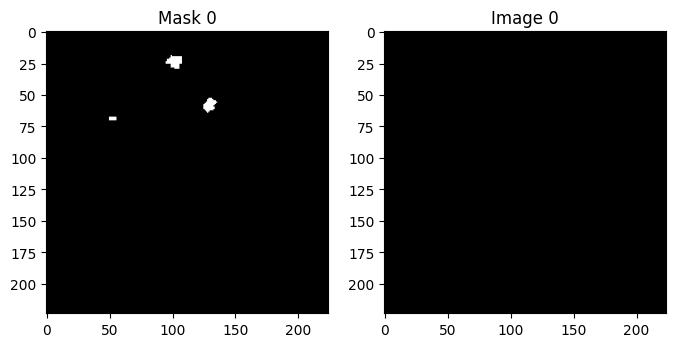

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1175096..-2.1013763].


Sample 1: values=[0.], counts=[50176]


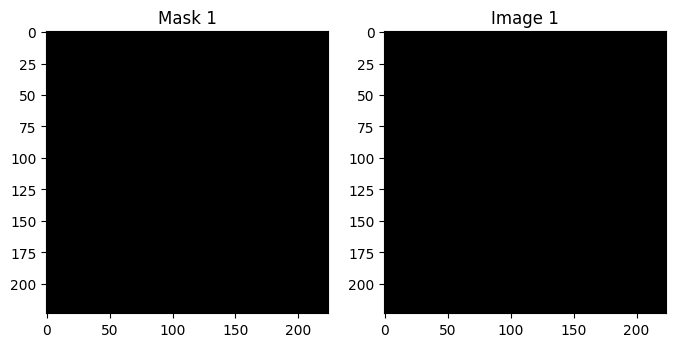

Sample 2: values=[0.], counts=[50176]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1173677..-2.1007793].


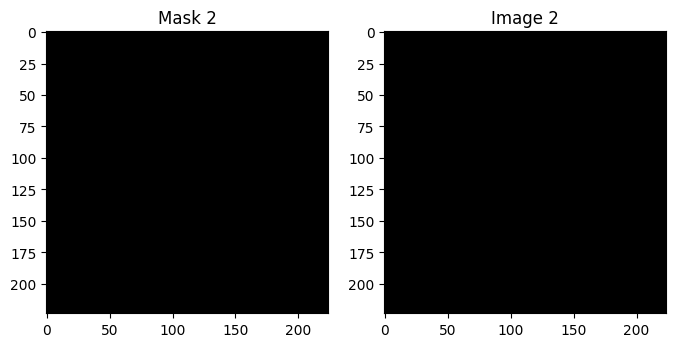

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-2.1026778].


Sample 3: values=[0.], counts=[50176]


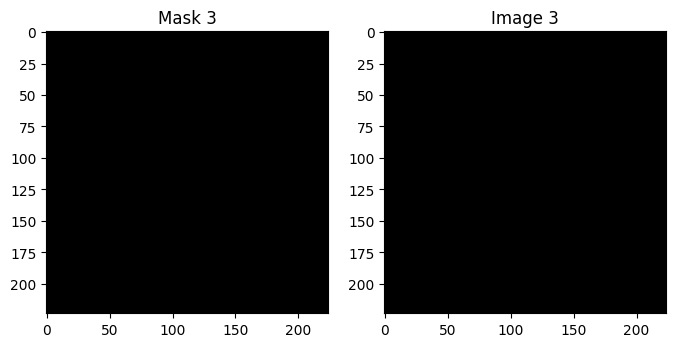

Sample 4: values=[0.], counts=[50176]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117219..-2.102029].


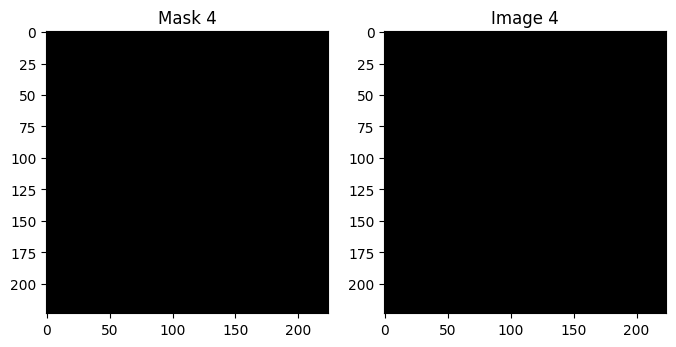

Testing: 100%|██████████| 1866/1866 [03:59<00:00,  7.78it/s]


Test Mean IoU: 0.7417
Test Mean Dice: 0.7417
Predicted positives: 0
True positives: 629086
Confusion Matrix:
[[92999330        0]
 [  629086        0]]
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


In [13]:
import os
import glob
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import tifffile
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from shapely import wkt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# --- Mask Creation from WKT ---
def create_mask_from_wkt(image_shape, wkt_list):
    mask = Image.new('L', image_shape[::-1], 0)
    draw = ImageDraw.Draw(mask)
    for wkt_str in wkt_list:
        poly = wkt.loads(wkt_str)
        coords = [(x, y) for x, y in np.array(poly.exterior.coords)]
        draw.polygon(coords, outline=1, fill=1)
    return np.array(mask, dtype=np.uint8)

# --- Dataset ---
class DisasterSegmentationDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = tifffile.imread(sample['pre_image_path'])
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        img /= img.max() if img.max() > 0 else 1
        img_pair = np.concatenate([img, img], axis=0)  # [6, H, W]
        mask = sample['mask'].astype(np.float32)
        if self.transform:
            augmented = self.transform(image=img_pair.transpose(1,2,0), mask=mask)
            img_pair = augmented['image']
            mask = augmented['mask']
        return img_pair, mask

# --- Test Data Preparation ---
test_image_folder = "/Volumes/Extreme SSD/DL_Proj/geotiffs/test/images"
test_label_folder = "/Volumes/Extreme SSD/DL_Proj/geotiffs/test/labels"
damage_types = ['major-damage', 'minor-damage', 'destroyed']

test_json_files = glob.glob(os.path.join(test_label_folder, "*.json"))
test_samples = []
for json_file in tqdm(test_json_files, desc="Loading Test JSONs"):
    img_name = os.path.splitext(os.path.basename(json_file))[0]
    img_path = os.path.join(test_image_folder, img_name + ".tif")
    if not os.path.exists(img_path):
        img_path = os.path.join(test_image_folder, img_name + ".png")
    img = tifffile.imread(img_path)
    height, width = img.shape[:2]
    with open(json_file) as f:
        data = json.load(f)
    wkt_list = []
    for poly in data['features']['xy']:
        subtype = poly.get('properties', {}).get('subtype', None)
        if subtype in damage_types and 'wkt' in poly:
            wkt_list.append(poly['wkt'])
    mask = create_mask_from_wkt((height, width), wkt_list)
    test_samples.append({
        'pre_image_path': img_path,
        'post_image_path': img_path,
        'mask': mask
    })

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485]*6, std=[0.229]*6),
    ToTensorV2()
])

test_dataset = DisasterSegmentationDataset(test_samples, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1)

# --- Mask Statistics and Visualization ---
print("Mask statistics for first 5 samples:")
for i in range(min(5, len(test_dataset))):
    _, mask = test_dataset[i]
    unique, counts = np.unique(mask.numpy(), return_counts=True)
    print(f"Sample {i}: values={unique}, counts={counts}")
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(mask.numpy(), cmap='gray')
    plt.title(f"Mask {i}")
    plt.subplot(1,2,2)
    img_pair, _ = test_dataset[i]
    img = img_pair[:3].permute(1,2,0).numpy()
    plt.imshow(img)
    plt.title(f"Image {i}")
    plt.show()

# --- Load Model (MUST match training encoder and in_channels) ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = smp.Unet(
    encoder_name="resnet50",  # Must match your training code!
    encoder_weights="imagenet",
    in_channels=6,
    classes=1,
    activation=None
).to(device)
model.load_state_dict(torch.load("best_weights2.pt", map_location=device))
model.eval()

# --- IoU and Dice metric functions ---
def compute_iou(pred, target):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2))
    union = ((pred + target) > 0).float().sum(dim=(1,2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def compute_dice(pred, target):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2))
    dice = (2 * intersection + 1e-6) / (pred.sum(dim=(1,2)) + target.sum(dim=(1,2)) + 1e-6)
    return dice.mean().item()

ious = []
dices = []
all_preds = []
all_targets = []

with torch.no_grad():
    for img_pair, mask in tqdm(test_loader, desc="Testing"):
        img_pair, mask = img_pair.to(device), mask.to(device)
        output = model(img_pair)
        pred = torch.sigmoid(output.squeeze(1))
        pred_bin = (pred > 0.5).cpu().numpy().astype(np.uint8)
        mask_bin = (mask > 0.5).cpu().numpy().astype(np.uint8)
        ious.append(compute_iou(pred.cpu(), mask.cpu()))
        dices.append(compute_dice(pred.cpu(), mask.cpu()))
        all_preds.append(pred_bin.flatten())
        all_targets.append(mask_bin.flatten())

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)
print(f"Test Mean IoU: {mean_iou:.4f}")
print(f"Test Mean Dice: {mean_dice:.4f}")

# --- Confusion Matrix, Precision, Recall, F1 ---
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

print("Predicted positives:", np.sum(all_preds))
print("True positives:", np.sum(all_targets))

cm = confusion_matrix(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)
f1 = f1_score(all_targets, all_preds, zero_division=0)

print("Confusion Matrix:")
print(cm)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim

# --- 1. Combine all CSVs ---
def combine_csvs(root_folder):
    all_csvs = glob.glob(os.path.join(root_folder, '**', '*.csv'), recursive=True)
    dfs = [pd.read_csv(csv) for csv in all_csvs]
    combined = pd.concat(dfs, ignore_index=True)
    return combined

folder = "/Volumes/Extreme SSD/DL_Proj/ISCRAM18_datasets"
df = combine_csvs(folder)
df = df.fillna(0)

# --- 2. Preprocess ---
if 'disaster_type' in df.columns:
    df['disaster_type'] = LabelEncoder().fit_transform(df['disaster_type'])
else:
    raise ValueError("Column 'disaster_type' not found in CSVs.")

if 'is_disaster' not in df.columns:
    df['is_disaster'] = (df['disaster_type'] > 0).astype(int)

drop_cols = ['is_disaster', 'disaster_type']
feature_cols = [col for col in df.columns if col not in drop_cols]
X = df[feature_cols].values.astype(np.float32)
y_bin = df['is_disaster'].values.astype(np.float32)
y_multi = df['disaster_type'].values.astype(np.int64)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- 3. Train/Test Split ---
X_train, X_test, y_bin_train, y_bin_test, y_multi_train, y_multi_test = train_test_split(
    X, y_bin, y_multi, test_size=0.2, random_state=42
)

# --- 4. PyTorch Dataset ---
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_bin_ds = TabularDataset(X_train, y_bin_train)
test_bin_ds = TabularDataset(X_test, y_bin_test)
train_multi_ds = TabularDataset(X_train, y_multi_train)
test_multi_ds = TabularDataset(X_test, y_multi_test)

train_bin_loader = torch.utils.data.DataLoader(train_bin_ds, batch_size=128, shuffle=True)
test_bin_loader = torch.utils.data.DataLoader(test_bin_ds, batch_size=128)
train_multi_loader = torch.utils.data.DataLoader(train_multi_ds, batch_size=128, shuffle=True)
test_multi_loader = torch.utils.data.DataLoader(test_multi_ds, batch_size=128)

# --- 5. Complex PyTorch Models ---
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out += residual
        return out

class DisasterBinaryModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, 256)
        self.bn_in = nn.BatchNorm1d(256)
        self.res1 = ResidualBlock(256)
        self.res2 = ResidualBlock(256)
        self.fc_out = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.bn_in(self.fc_in(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.fc_out(x).squeeze(1)
        return x

class DisasterMultiModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, 256)
        self.bn_in = nn.BatchNorm1d(256)
        self.res1 = ResidualBlock(256)
        self.res2 = ResidualBlock(256)
        self.fc_out = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn_in(self.fc_in(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.fc_out(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[1]
num_classes = len(np.unique(y_multi))

bin_model = DisasterBinaryModel(input_dim).to(device)
multi_model = DisasterMultiModel(input_dim, num_classes).to(device)

# --- 6. Training Loops with LR Scheduler ---
def train_model(model, loader, criterion, optimizer, scheduler, epochs=30):
    model.train()
    for epoch in range(epochs):
        losses = []
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        scheduler.step(np.mean(losses))
        print(f"Epoch {epoch+1}/{epochs} Loss: {np.mean(losses):.4f}")

# Binary
bin_criterion = nn.BCEWithLogitsLoss()
bin_optimizer = optim.AdamW(bin_model.parameters(), lr=1e-3, weight_decay=1e-4)
bin_scheduler = optim.lr_scheduler.ReduceLROnPlateau(bin_optimizer, patience=5, factor=0.5)
train_model(bin_model, train_bin_loader, bin_criterion, bin_optimizer, bin_scheduler, epochs=30)

# Multi-class
multi_criterion = nn.CrossEntropyLoss()
multi_optimizer = optim.AdamW(multi_model.parameters(), lr=1e-3, weight_decay=1e-4)
multi_scheduler = optim.lr_scheduler.ReduceLROnPlateau(multi_optimizer, patience=5, factor=0.5)
train_model(multi_model, train_multi_loader, multi_criterion, multi_optimizer, multi_scheduler, epochs=30)

# --- 7. Evaluation ---
def eval_binary(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            out = torch.sigmoid(model(Xb)).cpu().numpy()
            preds.extend((out > 0.5).astype(int))
            targets.extend(yb.numpy())
    print("Binary Accuracy:", accuracy_score(targets, preds))
    print(classification_report(targets, preds))

def eval_multi(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            out = model(Xb).cpu().numpy()
            preds.extend(np.argmax(out, axis=1))
            targets.extend(yb.numpy())
    print("Multi-class Accuracy:", accuracy_score(targets, preds))
    print(classification_report(targets, preds))

eval_binary(bin_model, test_bin_loader)
eval_multi(multi_model, test_multi_loader)

# --- 8. Save Models ---
torch.save(bin_model.state_dict(), 'disaster_binary_model_best.pt')
torch.save(multi_model.state_dict(), 'disaster_type_model_best.pt')

ParserError: Error tokenizing data. C error: Expected 1 fields in line 19, saw 2
